In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using CSV
Pkg.add("DifferentialEquations")
Pkg.add("Optim")
using Optim
using Plots

 Activating environment at `/mnt/c/git/ccse/sir/Project.toml`


0.3151429729753611

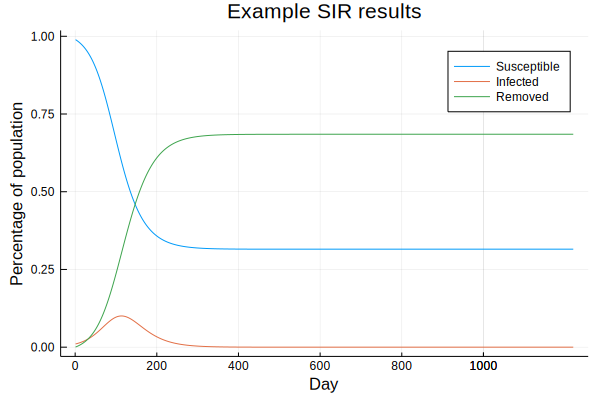

In [4]:
dt = 0.5
lambda = 1.0/6
gam = 1.0/10

struct SIR
    susceptible::Float64
    infected::Float64
    removed::Float64
end

function update_SIR(current::SIR)
    s = current.susceptible
    i = current.infected
    r = current.removed
    new = SIR(s - lambda * s * i * dt, i + lambda * s * i * dt - gam * i * dt, r + gam * i * dt)
end

t_final = 610
n_steps = round(Int64, t_final / dt)
result = Array{Float64}(undef, n_steps, 3)
time = 1:n_steps
sir = SIR(0.99, 0.01, 0.00)
for step = time
    sir = update_SIR(sir)
    result[step,1] = sir.susceptible
    result[step,2] = sir.infected
    result[step,3] = sir.removed
end
print(result[n_steps,1])

using Plots
gr()
plot(time, result, title="Example SIR results", xlabel="Day", ylabel="Percentage of population", labels = ["Susceptible" "Infected" "Removed"])

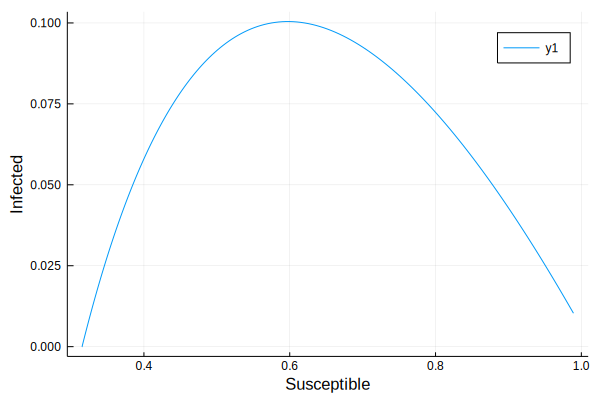

In [5]:
plot(result[:,1], result[:,2], xlabel="Susceptible", ylabel="Infected")

In [11]:
x = CSV.read("au_covid.csv", transpose=true)
print(x)

71×8 DataFrames.DataFrame
│ Row │ Australian Capital Territory │ New South Wales │ Northern Territory │ Queensland │ South Australia │ Tasmania │ Victoria │ Western Australia │
│     │ Int64                        │ Int64           │ Int64              │ Int64      │ Int64           │ Int64    │ Int64    │ Int64             │
├─────┼──────────────────────────────┼─────────────────┼────────────────────┼────────────┼─────────────────┼──────────┼──────────┼───────────────────┤
│ 1   │ 0                            │ 0               │ 0                  │ 0          │ 0               │ 0        │ 0        │ 0                 │
│ 2   │ 0                            │ 0               │ 0                  │ 0          │ 0               │ 0        │ 0        │ 0                 │
│ 3   │ 0                            │ 0               │ 0                  │ 0          │ 0               │ 0        │ 0        │ 0                 │
│ 4   │ 0                            │ 0               │ 0          

│ 58  │ 4                            │ 307             │ 1                  │ 144        │ 42              │ 10       │ 121      │ 52                │
│ 59  │ 6                            │ 353             │ 3                  │ 184        │ 50              │ 10       │ 121      │ 64                │
│ 60  │ 9                            │ 436             │ 3                  │ 221        │ 67              │ 16       │ 229      │ 90                │
│ 61  │ 19                           │ 669             │ 5                  │ 259        │ 100             │ 22       │ 355      │ 120               │
│ 62  │ 32                           │ 669             │ 5                  │ 319        │ 134             │ 28       │ 355      │ 140               │
│ 63  │ 39                           │ 818             │ 6                  │ 397        │ 170             │ 28       │ 411      │ 175               │
│ 64  │ 39                           │ 1029            │ 6                  │ 443        │ 170

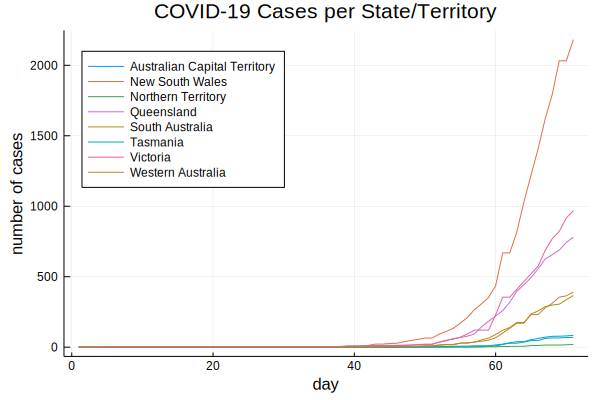

In [33]:
states = convert(Matrix, x)
state_names = reshape(String.(names(x)), 1, :)
plot(states, title="COVID-19 Cases per State/Territory", xlabel="Day", ylabel="Number of cases", labels=state_names, legend=:topleft)

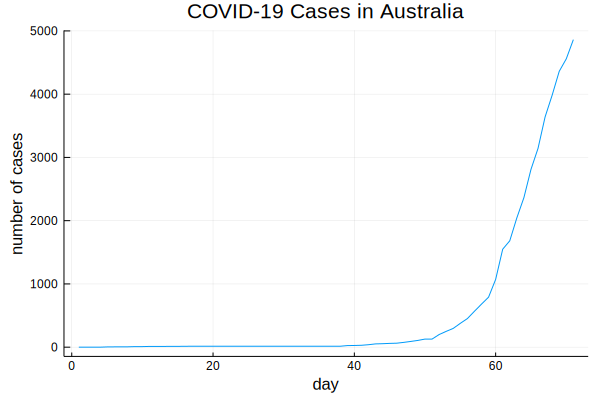

In [57]:
national=sum(states,dims=2)
plot(national,title="COVID-19 Cases in Australia", xlabel="Day", ylabel="Number of cases", legend=false)

2.499293025394235e7

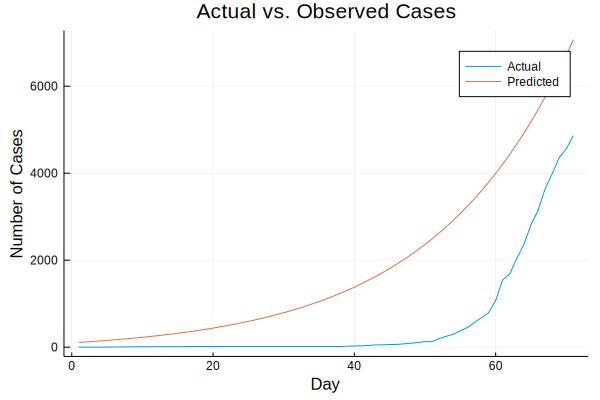

In [197]:
dt = 1.0
popsize=25000000
lambda = 0.1/popsize
gam = 1.0/21
t_final = size(states,1)
n_steps = round(Int64, t_final / dt)
result = Array{Float64}(undef, n_steps, 3)
time = 1:n_steps
sir = SIR(popsize-100.0,100.0,0.0)
for step = time
    sir = update_SIR(sir)
    result[step,1] = sir.susceptible
    result[step,2] = sir.infected
    result[step,3] = sir.removed
end
print(result[n_steps,1])
predicted=result[:,2]+result[:,3]

plot(time, [national,predicted], title="Actual vs. Observed Cases", xlabel="Day", ylabel="Number of Cases", labels = ["Actual" "Predicted"])

beta = 0.0181328125 gamma = 0.0109375
(0.0, 71)
(3, 92)
[2.5e7 2.4999996886215802e7 2.4999992164644238e7 2.499997629036134e7 2.49999342368091e7 2.499980661389131e7 2.4999418604555268e7 2.4998188303111453e7 2.49941955068756e7 2.498093457890738e7; 1.0 4.113784123022403 8.835355572696093 24.709638086625922 66.76318931207184 194.3861040215264 582.3954307021941 1812.6968448314753 5805.492984332851 19066.420632438356; 0.0 7.51279301688919e-8 1.8904782049591865e-7 5.720553184152529e-7 1.5867055282711576e-6 4.665947410826099e-6 1.4027799729037806e-5 4.371335567365247e-5 0.00014006433277117703 0.0004601768361791591]

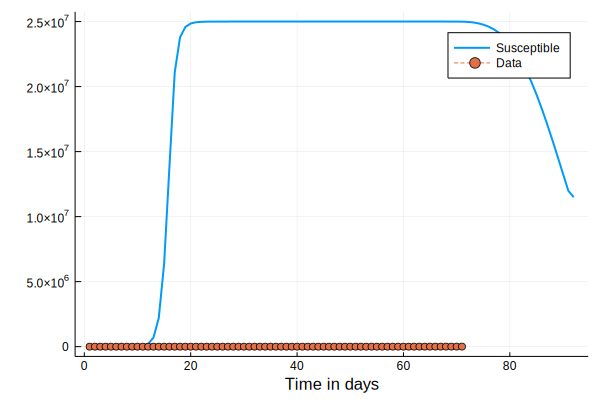

In [189]:
function SIR!(du,u,p,t)
    S,I,R = u
    β,γ = p
    du[1] = dS = -β*I*S
    du[2] = dI = β*I*S - γ*I
    du[3] = dR = γ*I
end

#t_final=14
#data = [1, 3, 6, 25, 73, 222, 294, 258, 237, 191, 125, 69, 27, 11, 4]
#popsize=762

t_final = size(national,1)
data = national[:]
popsize=25000000

tspan = (0.0,t_final)
u0 = [popsize,1.0,0.0]


function ss(x)
    prob = ODEProblem(SIR!,u0,tspan,(x[1],x[2]))
    sol = solve(prob)
    pred_total_cases = sol(1:t_final)[2,:]+sol(1:t_final)[3,:]
    return(sum((pred_total_cases - data) .^2))
end

opt = optimize(ss,[0.001,0.01],NelderMead())
beta,gamma = opt.minimizer
println("beta = ",beta," gamma = ",gamma)
println(tspan)
prob = ODEProblem(SIR!,u0,tspan,(beta,gamma))
sol = solve(prob)
println(size(sol))
predicted=sol[2,:]
print(sol[:,1:10])
plot(predicted,
    linewidth=2,
    xaxis="Time in days",
    labels=["Susceptible" "Infected" "Removed"])
plot!([1:t_final],data,linestyle=:dash,marker=:circle,markersize=4,label="Data")